# Машинное обучение, ФКН ВШЭ

## Практическое задание 10. Рекомендательные системы

### Общая информация

Дата выдачи: 09.05.2020  

Мягкий дедлайн: 23:59MSK 24.05.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 27.05.2020


### О задании
В этом задании мы будем практиковаться в построении рекомендательных систем: научимся считать метрики и пообучаем модели.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tqdm

### Данные

Будем работать с датасетом  от онлайн-кинотеатра Okko [REKKO CHALLENGE](https://boosters.pro/championship/rekko_challenge/data).

Имеющиеся данные содержат несколько файлов. Рассмотрим всё, что у нас есть.

`catalogue.json` содержит анонимизированную метаинформацию о доступных в сервисе фильмах и сериалах:

In [2]:
catalogue = pd.read_json('data/catalogue.json', orient='values').T

In [3]:
catalogue['element_uid'] = catalogue.index

In [4]:
catalogue.head()

,type,availability,duration,feature_1,feature_2,feature_3,feature_4,feature_5,attributes,element_uid
1983,movie,"[purchase, rent, subscription]",140,1.65722e+06,0.75361,39,1.11941,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1983
3783,movie,"[purchase, rent, subscription]",110,3.55652e+07,0.766254,41,1.1386,0.654707,"[1, 26, 27, 28, 29, 7, 30, 31, 32, 10, 14, 15,...",3783
5208,movie,"[purchase, rent, subscription]",90,1.32707e+07,0.765425,27,1.13181,0.592716,"[1, 38, 39, 40, 7, 41, 42, 43, 14, 15, 17, 18,...",5208
9744,movie,"[purchase, rent, subscription]",120,2.17499e+07,0.757874,26,1.13353,0.654707,"[1, 47, 48, 49, 50, 51, 52, 53, 32, 42, 54, 14...",9744
1912,movie,"[purchase, rent]",110,9.21296e+06,0.759566,7,1.11013,0.654707,"[1, 59, 60, 61, 62, 7, 52, 63, 10, 42, 54, 17,...",1912


 - `attributes` — мешок атрибутов;
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`);
 - `duration` — длительность фильма (для сериалов и многосерийных фильмов — длительность серии) в минутах, округлённая до десятков;
 - `feature_1..5` — пять анонимизированных вещественных и порядковых признаков;
 - `type` — принимает значения `movie`, `multipart_movie` или `series`.

`transactions.csv` — список всех транзакций за определённый период времени:

In [5]:
transactions = pd.read_csv('data/transactions.csv',
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

In [6]:
transactions.head()

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50


In [7]:
transactions.shape

(9643012, 7)

 - `element_uid` — идентификатор элемента (фильма);
 - `user_uid` — идентификатор пользователя;
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке);
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке;
 - `watched_time` — число просмотренных по транзакции секунд;
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр;
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр.

`ratings.csv` содержит информацию о поставленных пользователями оценках:

In [8]:
ratings = pd.read_csv('data/ratings.csv')

In [9]:
ratings.head()

,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07
3,359870,1364,10,4.430506e+07
4,359870,3578,9,4.430506e+07


In [10]:
ratings.shape

(438790, 4)

 - `rating` — поставленный пользователем рейтинг (от `0` до `10`).

Далее будем обучать модель на долю времени просмотра фильма. Для этого к матрице `transactions` добавим информацию о длительности фильма.

In [11]:
transactions = transactions.merge(catalogue, how='left', on='element_uid')

 В колонке `transactions['duration']` могут быть нули, так как значения округляются до ближайшей десятки. Поэтому добавим 10 ко всем значениям. И умножим все значения `transactions['duration']` на 60, чтобы перевести в секунды. 

In [12]:
transactions.loc[:, 'duration'] += 10
transactions['duration']  = transactions['duration']*60

Для простоты вычислений далее будем использовать не всех пользователей.

In [13]:
transactions_small = transactions.loc[transactions.user_uid < transactions.user_uid.quantile(.01)]

In [14]:
transactions.element_uid.nunique()

8296

Чтобы оценивать качество предсказаний построенных алгоритмов, разобьем данные на обучающую и тестовую выборки. Для этого вычислим 75-й перцентиль признака `ts` и разделим данные `transactions_small` во времени, так, чтобы в обучающую выборку попало 75% данных, а в тестовую — остальные 25%.

In [15]:
transactions_test = transactions_small.loc[transactions_small.ts > transactions_small.ts.quantile(.75)].reset_index()
transactions_train = transactions_small.loc[transactions_small.ts < transactions_small.ts.quantile(.75)].reset_index()

In [16]:
transactions_train.shape

(72319, 17)

In [17]:
transactions_train.user_uid.nunique()

4498

In [18]:
transactions_test.user_uid.nunique()

2733

Данные `ratings` тоже необходимо сократить и исключить оценки из тестовой части:

In [19]:
test_user_ids = set(transactions_test[['element_uid', 'user_uid']].itertuples(index=False))
train_user_ids = set(transactions_train[['element_uid', 'user_uid']].itertuples(index=False))
drop_index = []
for row in tqdm.tqdm(ratings.itertuples()):
    if (row.element_uid, row.user_uid) in test_user_ids or not (row.element_uid, row.user_uid) in train_user_ids:
        drop_index.append(row.Index)

438790it [00:01, 220013.55it/s]


In [20]:
ratings.drop(drop_index, inplace=True)
ratings.reset_index(inplace=True)

In [21]:
ratings.shape

(2836, 5)

In [22]:
ratings

,index,user_uid,element_uid,rating,ts
0,14329,2972,6195,9,4.418280e+07
1,14697,4695,8811,10,4.417677e+07
2,18712,1242,5589,5,4.414930e+07
3,18924,587,2923,10,4.414873e+07
4,22091,645,1935,10,4.413121e+07
...,...,...,...,...,...
2831,437629,3236,5644,4,4.173797e+07
2832,437751,575,2916,9,4.173749e+07
2833,437859,5373,8646,6,4.173715e+07
2834,438185,380,4319,9,4.173629e+07


На выделенной обучающей выборке необходимо обучить рекомендательную систему и предсказать top-20 наиболее релевантных для пользователя идентификаторов контента.

Получим значение целевой переменной для итогового алгоритма — долю времени просмотра фильма:

In [23]:
transactions_train['target'] = transactions_train.watched_time/transactions_train.duration

In [24]:
transactions_test['target'] = transactions_test.watched_time/transactions_test.duration

В поле `target` присутствуют значения больше 1, так как для сериалов и многосерийных фильмов используется средняя длина серии — заменим в таких случаях целевую переменную на 1:

In [25]:
transactions_train.loc[transactions_train['target'] > 1, 'target'] = 1
transactions_test.loc[transactions_test['target'] > 1, 'target'] = 1

Далее в задании везде будем обозначать как $r_{ui}$ значение этой целевой переменной для пользователя $u$ и элемента $i$.

### Задание 0

Для оценки качества предсказаний будем использовать метрику $MNAP@20$, которую использовали в соревновании.
Метрика отличается от оригинальной $MAP$ тем, что значение для каждого пользователя нормализуется не на константу, а на число потреблённых фильмов. Таким образом, вес угадывания одного фильма больше у пользователей, имеющих меньшее число просмотров.


$$MNAP@20 = \dfrac{1}{|U|}\sum_{u\in U}\dfrac{1}{\min(n_u, 20)}\sum_{i=1}^{20}r_u(i)p_u@i $$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^kr_u(j)$$
- $r_{u}(i)$ — потребил ли пользователь u контент, предсказанный ему на месте i (1 либо 0);
- $n_u$ — количество элементов, которые пользователь потребил за тестовый период;
- $U$ — множество тестовых пользователей.

Реализуйте функцию `mnap_k`, вычисляющую метрику качества $MNAP@K$, где

- `predictions` — предсказания фильмов для пользователей  `List[List[int]]`;

- `target` — фильмы которые посмотрел пользователь  `List[Set[int]]`.

In [120]:
def mnap_k(predictions, target, k=20):
    n = len(predictions)
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・
    # r = [np.array(predictions[i]) == np.array(list(target[i])) for i in range(n)]
    r = [np.array([1 if predictions[i][j] in target[i] else 0 for j in range(len(predictions[i]))]) for i in range(n)]
    inner = [[r[u][i - 1] * r[u][:i].sum() / i for i in range(1, k + 1)] for u in range(n)]
    
    u_num = n
    user_score = []
    scores = np.array(inner).sum(axis=1)
    for u in range(n):
        if len(target[u]) == 0:
            scores[u] = 0
            u_num -= 1
        else:
            scores[u] /= min(len(target[u]), 20)
            
    
    # user_score = np.array(inner).sum(axis=1) / [min(len(target[u]), 20) for u in range(n) if len(target[u]) != 0]
    
    return np.array(scores).sum() / u_num


Проведем элементарные проверки на корректность реализации:

In [121]:
test = [list(np.arange(1, 21)), list(np.arange(2, 22)), list(np.arange(3, 23))]
target = [set(np.arange(1, 21)), set(np.arange(2, 22)), set(np.arange(3, 23))]
assert mnap_k(test, target) == 1.0

In [122]:
test = [list(np.arange(1, 21)), list(np.arange(2, 22)), list(np.arange(3, 23))]
target = [set(np.arange(1, 11)), set(np.arange(2, 12)), set(np.arange(3, 13))]
assert mnap_k(test, target) == 1.0

In [123]:
test = [list(np.arange(1, 21)), list(np.arange(2, 22)), list(np.arange(3, 23))]
target = [set(np.arange(2, 21)), set(np.arange(2, 22)), set(np.arange(3, 23))]
assert round(mnap_k(test, target), 3) == 0.954

### Задание 1



#### Memory-based
Два пользователя похожи, если им нравятся одинаковые фильмы.
Рассмотрим двух пользователей $u$ и $v$ и обозначим через $I_{uv}$ множество фильмов $i$, которые просмотрели пользователи:
$$
    I_{uv}
    =
    \{
        i \in I
        |
        \exists r_{ui}
        \ \&\ 
        \exists r_{vi}
    \}.
$$
Тогда сходство двух данных пользователей можно вычислить через корреляцию Пирсона:
$$
    w_{uv}
    =
    \frac{
        \sum_{i \in I_{uv}}
            (r_{ui} - \bar r_u)
            (r_{vi} - \bar r_v)
    }{
        \sqrt{
        \sum_{i \in I_{uv}}
            (r_{ui} - \bar r_u)^2
        }
        \sqrt{
        \sum_{i \in I_{uv}}
            (r_{vi} - \bar r_v)^2
        }
    },
$$
где $\bar r_u$ и $\bar r_v$ — средняя доля времени просмотра фильма для пользователей.

Чтобы вычислять сходства между элементами $i$ и $j$, введём множество пользователей $U_{ij}$, для которых известны целевые переменные для этих элементов:
$$
    U_{ij}
    =
    \{
        u \in U
        |
        \exists r_{ui}
        \ \&\ 
        \exists r_{uj}
    \}.
$$
Тогда сходство двух данных товаров можно вычислить через корреляцию Пирсона:
$$
    w_{ij}
    =
    \frac{
        \sum_{u \in U_{ij}}
            (r_{ui} - \bar r_i)
            (r_{uj} - \bar r_j)
    }{
        \sqrt{
        \sum_{u \in U_{ij}}
            (r_{ui} - \bar r_i)^2
        }
        \sqrt{
        \sum_{u \in U_{ij}}
            (r_{uj} - \bar r_j)^2
        }
    },
$$
где $\bar r_i$ и $\bar r_j$ — средняя доля времени просмотра для фильмов

Реализуйте класс `MemoryBased` с методами:

- `__init__` — конструктор класса, принимает на вход матрицу целевых переменных $r_{ui}$;
- `user_similarity` — возвращает вектор $w_u$ сходства пользователя $u$ и всех пользователей из обучающей выборки; если пользователь $u$ не встречался в обучающей выборке, то возвращайте нулевой вектор;
- `item_similarity` — возвращает вектор $w_i$ сходства фильма $i$ и всех фильмов из обучающей выборки; если фильм $i$ не встречался в обучающей выборке, то возвращайте нулевой вектор.



Уделите особое внимание оптимизации кода. Используйте векторизацию и матричные вычисления, где это возможно.

In [33]:
'''N = len(self.ratings)
        M = len(test_user)
        
        u = -1
        u = [ind for ind, user in enumerate(self.ratings) if (user == test_user).all()][0]
        if u == -1:
            return np.zeros(N)
        items = np.where(test_user != 0)[0]
        Iuv = [set() for i in range(N)]
        [[Iuv[v].add(i) for i in items  if v != u and self.ratings[v][i]] for v in range(N)] 
                    
        r_normalized = self.ratings - np.true_divide(self.ratings.sum(1),(self.ratings!=0).sum(1)).reshape(-1,1)
        
        result = [
            np.dot(r_normalized[u][list(Iuv[v])], r_normalized[v][list(Iuv[v])]) / (
                np.sqrt(
                    np.dot(r_normalized[u][list(Iuv[v])],r_normalized[u][list(Iuv[v])]) *
                    np.dot(r_normalized[v][list(Iuv[v])], r_normalized[v][list(Iuv[v])])
                )
            )
            if v != u
            else
            1.0
            for v in range(N)
        ]
        return result'''

N, M = self.ratings.shape
        if not len(np.where((self.ratings==test_user).all(axis=1))[0]):
            return np.zeros(N)
        
        ru = test_user.copy()
        ru[ru == 0] = np.nan
        ru = np.nan_to_num(ru -  np.nanmean(ru))
        
        if np.sum(ru) == 0:
            return np.zeros(N)
        
        R = self.ratings.copy()
        R[R==0] = np.nan
        R = R - np.nanmean(R, axis=1).reshape(-1, 1)
        mask = ~np.isnan(R)
        R = np.nan_to_num(R)
        R[:, [np.where(ru == 0)]] = 0
        result = np.nan_to_num(R.dot(ru) / (np.linalg.norm(mask*ru, axis=1)*np.linalg.norm(R, axis=1)))
        return result

'N = len(self.ratings)\n        M = len(test_user)\n        \n        u = -1\n        u = [ind for ind, user in enumerate(self.ratings) if (user == test_user).all()][0]\n        if u == -1:\n            return np.zeros(N)\n        items = np.where(test_user != 0)[0]\n        Iuv = [set() for i in range(N)]\n        [[Iuv[v].add(i) for i in items  if v != u and self.ratings[v][i]] for v in range(N)] \n                    \n        r_normalized = self.ratings - np.true_divide(self.ratings.sum(1),(self.ratings!=0).sum(1)).reshape(-1,1)\n        \n        result = [\n            np.dot(r_normalized[u][list(Iuv[v])], r_normalized[v][list(Iuv[v])]) / (\n                np.sqrt(\n                    np.dot(r_normalized[u][list(Iuv[v])],r_normalized[u][list(Iuv[v])]) *\n                    np.dot(r_normalized[v][list(Iuv[v])], r_normalized[v][list(Iuv[v])])\n                )\n            )\n            if v != u\n            else\n            1.0\n            for v in range(N)\n        ]\n   

In [135]:
class MemoryBased():
    def __init__(self, ratings):
        self.ratings = ratings
        # self.Iuv = [[set() for j in range(len(ratings[0]))] for i in range(len(ratings))]
        pass
        
    def user_similarity(self, test_user):
        """test_user - вектор соответствующий пользователю"""
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・
        N = len(self.ratings)
        M = len(test_user)
        
        u = -1
        u = [ind for ind, user in enumerate(self.ratings) if (user == test_user).all()][0]
        if u == -1:
            return np.zeros(N)
        items = np.where(test_user != 0)[0]
        Iuv = [set() for i in range(N)]
        [[Iuv[v].add(i) for i in items  if v != u and self.ratings[v][i]] for v in range(N)] 
                    
        r_normalized = self.ratings - np.true_divide(self.ratings.sum(1),(self.ratings!=0).sum(1)).reshape(-1,1)
        
        result = [
            np.dot(r_normalized[u][list(Iuv[v])], r_normalized[v][list(Iuv[v])]) / (
                np.sqrt(
                    np.dot(r_normalized[u][list(Iuv[v])],r_normalized[u][list(Iuv[v])]) *
                    np.dot(r_normalized[v][list(Iuv[v])], r_normalized[v][list(Iuv[v])])
                )
            )
            if v != u
            else
            1.0
            for v in range(N)
        ]
        return result
        
    def item_similarity(self, test_item):
        """test_item - вектор соответствующий фильму"""
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・
        M = len(self.ratings)
        N = len(self.ratings[0])
        
        i = -1
        i = [ind for ind, item in enumerate(self.ratings) if (item == test_item).all()][0]
        if i == -1:
            return np.zeros(M)
        users = np.where(test != 0)[0]
        Uij = [set() for i in range(M)]
        [[Uij[j].add(u) for j in range(M) if j != i and self.ratings[j][u]] for u in users]

        r_normalized = self.ratings - np.true_divide(self.ratings.sum(1),(self.ratings!=0).sum(1)).reshape(-1,1)
        
        result = [
            np.dot(r_normalized[i][list(Uij[j])], r_normalized[j][list(Uij[j])]) / (
                np.sqrt(
                    np.dot(r_normalized[i][list(Uij[j])],r_normalized[i][list(Uij[j])]) *
                    np.dot(r_normalized[j][list(Uij[j])],r_normalized[j][list(Uij[j])])
                )
            )
            if j != i
            else
            1.0
            for j in range(M)
        ]
        return result
    

Проведем элементарные проверки на корректность реализации:

In [136]:
I = np.array([[0.5, 0.4, 0, 0.1], 
         [0, 0.1, 0.2, 0.5], 
         [0.5, 0.5, 0.4, 0],
         [0.5, 0.4, 0.5, 0.1]])
item_based = MemoryBased(I)
result = item_based.user_similarity(np.array([0.5, 0.4, 0, 0.1]))
assert np.all(np.round(result, 2) == np.array([1.0, -0.94, 0.92, 0.97]))

### Задание 2

#### User-Based
В подходе на основе сходств пользователей
определяется множество $U(u_0)$ пользователей, похожих на данного:
$$
    U(u_0)
    =
    \{v \in U
        |
        w_{u_0 v} > \alpha
    \}.
$$
После этого для каждого товара вычисляется, как часто он покупался пользователями из $U(u_0)$:
$$
    p_{i}
    =
    \frac{
        |\{u \in U(u_0) | \exists r_{ui}\}|
    }{
        |U(u_0)|
    }.
$$
Пользователю рекомендуются $k$ товаров с наибольшими значениями $p_i$.
Данный подход позволяет строить рекомендации, если для данного пользователя найдутся похожие.
Если же пользователь является нетипичным, то подобрать что-либо не получится.

Реализуйте класс `UserBased`, наследованный от `MemoryBased`. Считайте, что $\alpha = 0$.

Класс `UserBased` должен иметь метод реализованный `recomendation_k` с параметром k, возвращающий матрицу предсказаний размера N x k (для каждого пользователя из user_vectors предсказывать top-k фильмов).

In [121]:
from tqdm import tqdm
class UserBased(MemoryBased):
    def recomendation_k(self, user_vectors, k=20):
        """user_vectors - матрица размера N x M, где M - общее число фильмов, N - число пользователей, для которых делаем рекомендации"""
        try:
            N, M = user_vectors.shape
        except:
            N, M = 1, len(user_vectors)
            user_vectors = user_vectors.reshape(1,-1)
        res = [[] for i in range(N)]
        for ind, user in enumerate(tqdm(user_vectors)):
            wu = np.array(self.user_similarity(user))
            # wu[ind] = 0
            U = np.where(wu > 0)[0]
            # where0 = np.where(user == 0)[0]
            # R = self.ratings[:, where0]
            where1 = np.where(user != 0)[0]
            if len(U) != 0:
                Pi = (self.ratings[U] != 0).sum(axis=0) / len(U)
            else:
                Pi = user
            Pi[where1]=0
            res[ind] = sorted(range(M), key=lambda mu: Pi[mu], reverse=True)
        return np.array(res)[:,:k]

Проведем элементарные проверки на корректность реализации:

In [122]:
I = np.array([[0.5, 0.4, 0, 0.1], 
         [0, 0.1, 0.2, 0.5], 
         [0.5, 0.5, 0.4, 0],
         [0.5, 0.4, 0.5, 0.1]])
check = UserBased(I)
res = check.recomendation_k(np.array([0.5, 0.4, 0, 0.1]), k=1)
res
assert np.all(res == np.array([2]))

100%|██████████| 1/1 [00:00<00:00, 136.03it/s]


### Задание 3

#### Item-Based 

Определяется множество фильмов, похожих на те, которые интересовали данного пользователя:
$$
    I(u_0)
    =
    \{
        i \in I
        |
        \exists r_{u_0 i_0},
        w_{i_0 i} > \alpha
    \}.
$$
Затем для каждого товара из этого множества вычисляется его сходство с пользователем:
$$
    p_i
    =
    \max_{i_0: \exists r_{u_0 i_0}}
    w_{i_0 i}.
$$
Пользователю рекомендуются $k$ фильмов с наибольшими значениями $p_i$.


Реализуйте класс `ItemBased`, наследованный от `MemoryBased`.

Класс `ItemBased` должен иметь метод реализованный `recomendation_k` с параметром k, возвращающий матрицу предсказаний размера N x k (для каждого пользователя из user_vectors предсказывать top-k фильмов).

In [172]:
class ItemBased(MemoryBased):
    def recomendation_k(self, user_vectors, k=20):
        """user_vectors - матрица размера N x M, где M - общее число фильмов, N - число пользователей, для которых делаем рекомендации"""
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・
        try:
            N, M = user_vectors.shape
        except:
            N, M = 1, len(user_vectors)
            user_vectors = user_vectors.reshape(1,-1)
            
        w = []
        res = [[] for i in range(N)]
        
        for i in tqdm(range(M)):
            w.append(np.array(self.item_similarity(self.ratings[i])))
                    
        for ind, u0 in enumerate(tqdm(user_vectors)):
            i0_s = np.where(u0 != 0)[0]
            I_u0 = set()
            for i0 in i0_s:
                I_u0.update(np.where(w[i0] > 0)[0])
            P = np.zeros(M)
            for i in I_u0:
                P[i] = np.max(w[i][i0_s])
            res[ind] = sorted(range(M), key=lambda mu: P[mu], reverse=True)
        return np.array(res)[:,:k]

In [173]:
I = np.array([[0.5, 0.4, 0, 0.1], 
         [0, 0.1, 0.2, 0.5], 
         [0.5, 0.5, 0.4, 0],
         [0.5, 0.4, 0.5, 0.1]])
item_based = ItemBased(I.T)
res = item_based.recomendation_k(np.array([0.5, 0.5, 0.4, 0]), k=1)
res

100%|██████████| 1/1 [00:00<00:00, 512.13it/s]


array([[0]])

### Задание 4

Сформируйте матрицы $R = \{r_{ui}\}_{u \in U, \, i \in I}$ по данным `transactions_train` и `transactions_test`, где $r_{ui}$ — доля времени взаимодействовия пользователя с фильмом.

С помощью Item-Based и User-Based подходов получите предсказания для пользователей из тестовой выборки и оцените качество с помощью реализованной в задании 0 функции `mnap_k` при `k=20`.

In [123]:
R_train = transactions_train.pivot(index='user_uid', columns='element_uid', values='target')
R_train.fillna(0, inplace=True)

In [124]:
R_test = transactions_test.pivot(index='user_uid', columns='element_uid', values='target')
R_test.fillna(0, inplace=True)

In [125]:
R_train.shape, R_test.shape

((4498, 5124), (2733, 3578))

In [126]:
train_items = set(R_train.columns)
test_items = set(R_test.columns)
to_add = test_items - train_items.intersection(test_items)

In [127]:
R_train_on = pd.concat([R_train,pd.DataFrame(columns=to_add)])
R_train_on.fillna(0, inplace=True)

In [128]:
R = R_train_on.reindex(R_test.index, fill_value=0.0)
R.fillna(0, inplace=True)
R = R.to_numpy()

In [129]:
R_test_mat = R_test.to_numpy()
R_train_mat = R_train_on.to_numpy()

In [ ]:
ub = UserBased(R_train_mat)
predict_ub = ub.recomendation_k(R, k=20)

  0%|          | 0/2733 [00:00<?, ?it/s]/home/dilara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/dilara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
  0%|          | 5/2733 [00:05<50:51,  1.12s/it]/home/dilara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
 15%|█▌        | 412/2733 [04:48<29:19,  1.32it/s]

In [131]:
items = list(list(R_train_on.columns))
to_map = dict(zip(range(len(items)), items))
predict = np.vectorize(to_map.get)(predict_ub)

In [132]:
target = []

R_tmp = (R_test != 0)
for user_id in list(R_tmp.index):
    target.append(set(R_tmp.loc[user_id][R_tmp.loc[user_id] != 0].index))

In [134]:
mnap_k(predict, target)

0.012139236896329501

In [134]:
mnap_k(predict, target)

0.013785710752946738

In [174]:
ib = ItemBased(R_train_mat.T)
predict_ib = ib.recomendation_k(R, k=20)

  0%|          | 0/5552 [00:00<?, ?it/s]/home/dilara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/dilara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 2733/2733 [00:06<00:00, 450.08it/s]


In [175]:
predict2 = np.vectorize(to_map.get)(predict_ib)

In [176]:
mnap_k(predict2, target)

0.0007968460195996637

### Задание 5

#### Latent factor model (LFM)

В этом подходе значение целовой переменной $r_{ui}$ пользователя $u$, поставленная фильму $i$, ищется как скалярное произведение векторов $p_u$ и $q_i$ в некотором пространстве $R^K$ латентных признаков:
$$
    r_{ui}
    \approx
    \langle p_u, q_i \rangle.
$$



Иными словами, модель находит пространство признаков, в котором мы описываем и фильмы, и пользователей и в котором целевая переменная является мерой близости между фильмами и пользователями.

Для настройки модели будем минимизировать следующий функционал:

\begin{equation}
\label{eq:lfmReg}
    \sum_{(u, i) \in R}
        \left(
            r_{ui}
            - \langle p_u, q_i \rangle
        \right)^2
    +
    \lambda
    \sum_{u \in U}
        \|p_u\|^2
    +
    \mu
    \sum_{i \in I}
        \|q_i\|^2
    \to
    \min_{P, Q}
\end{equation}

В [статье](https://dl.acm.org/doi/10.1145/1864708.1864726) описан метод оптимизации ALS (Alternating Least Squares) для данного функционала.
В методе проводятся $N$ итераций, в рамках каждой итерации сначала оптимизируется $p$ при фиксированном
$q$, затем $q$ при фиксированном $p$.

Составим матрицу $P$ из векторов $p_u$ и матрицу $Q$ из векторов $q_i$. Матрицей $Q[u] \in R^{n_u×K}$ будем обозначать подматрицу матрицы $Q$ только для товаров, оцененных пользователем $u$, где $n_u$ – количество оценок пользователя $u$.
Шаг перенастройки $p_u$ при фиксированной матрице $Q$ сводится к настройке Ridge-регрессии и выглядит так:
$$A_u = Q[u]^T Q[u] $$
$$d_u = Q[u]^Tr_u $$
$$p_u = (\lambda n_uI + A_u)^{−1}d_u
$$

Выпишите формулы для перенастройки $q_i$ при фиксированной матрице $P$.

**Ответ:**

$$A_i = P[i]^T P[i] $$
$$d_i = P[i]^Tr_i $$
$$q_i = (\mu n_iI + A_i)^{−1}d_i
$$

Реализуйте функцию `latent_factor`, которая для каждого пользователя из списка `test` возвращает top-k идентификаторов контента (`element_uid`).

Для тестирования матрицы `P` и `Q` задайте случайными `0.1 * np.random.random(...)`.

Исследуйте качество и время работы в зависимости от размерности $K$
пространства латентных признаков. Ведет ли увеличение $K$ к переобучению?


In [147]:
from scipy.sparse import *
from scipy.sparse.linalg import norm

def score(R_sparce, Q, P):
    P_sparce = csr_matrix(P)
    Q_sparce = csr_matrix(Q)
    
    a = norm(R_sparce - np.dot(P_sparce, Q_sparce.T), 'fro') ** 2
    b = lambda_ * norm(P_sparce, 'fro') ** 2
    c = mu * norm(Q_sparce, 'fro') ** 2
    return  a + b + c

In [93]:
def descent(P, Q, R, E, lambda_, mu, tolerance = 1e-4):
    loss = []
    loss.append(score(csr_matrix(R), Q, P))
    
    K = P.shape[1]
    U, I = R.shape
    
    for e in tqdm(range(E)):
        P_new = P.copy()
        Q_new = Q.copy()
        for u in range(U):
            Iu = np.where(R[u] != 0)[0]
            A = np.dot(Q[Iu].T, Q[Iu])
            nu = len(Iu)
            ru = R[u][Iu]
            E = lambda_ * np.eye(K)
            pu = np.linalg.lstsq(E + A, np.dot(Q[Iu].T, ru))[0]
            P_new[u] = pu
        if np.linalg.norm(P_new - P, ord=2) <= tolerance:
            P = P_new.copy()
            break
        P = P_new.copy()
                
        for i in range(I):
            Ui = np.where(R[:,i] != 0)[0]
            A = np.dot(P[Ui].T, P[Ui])
            ni = len(Ui)
            ri = R[:,i][Ui]
            E = mu * np.eye(K)
            qi = np.linalg.lstsq(E + A, np.dot(P[Ui].T, ri))[0]
            Q_new[i] = qi
        if np.linalg.norm(Q_new - Q, ord=2) <= tolerance:
            Q = Q_new.copy()
            break
        Q = Q_new.copy()
        loss.append(score(csr_matrix(R), Q, P))
    return P, Q, loss

In [94]:
def latent_factor(train, target, test, lambda_, mu, N, K, P, Q, k = 20):
    new_users = set(test) - set(test).intersection(set(train['user_uid'].values))
    # test = list(set(test).intersection(set(train['user_uid'].values)))
    
    R = train
    R['target'] = target
    R = R.pivot(index='user_uid', columns='element_uid', values='target')
    R.fillna(0, inplace=True)
    
    pp, qq, loss = descent(P, Q, R.to_numpy(), N, lambda_, mu)
    res = np.dot(pp, qq.T)

    new_R = pd.DataFrame(res, columns = list(R.columns), index =list(R.index))
    most_popular = list(np.sum(new_R != 0).sort_values(ascending=False).index)[:k]

    recommendation = []
    for user_id in test:
        if user_id in new_users:
            top_k = most_popular.copy()
        else:
            top_k = list(new_R.loc[user_id].sort_values(ascending=False).index)[:k]
        recommendation.append(top_k)
        
    return np.array(recommendation), loss

In [227]:
import warnings
warnings.simplefilter("ignore")
from tqdm import tqdm

train = pd.DataFrame({'user_uid': [1, 1, 2, 2], 'element_uid': [1, 2, 3, 4]})
target =  np.array( [0.1, 0.8, 0.2, 0.3 ])
test = np.array([1, 2])
lambda_ = 0.2
mu = 0.001
N = 20
K = 10
us = train.loc[:,'user_uid'].astype('int')
mov = train.loc[:,'element_uid'].astype('int')
U = np.unique(us)
I = np.unique(mov)
Q = 0.1 * np.ones((I.max(), K))
P = 0.1 * np.ones((U.max(), K))
assert np.all(latent_factor(train, target, test, lambda_, mu, N, K, P, Q, k = 1)[0] == np.array([[2], [2]]))

100%|██████████| 20/20 [00:00<00:00, 245.87it/s]


Оцените  качество разботы функции `latent_factor` на тестовой выборке по метрике `mnap_k` при `k=20`.

In [233]:
train = transactions_train[['user_uid', 'element_uid']]
target = transactions_train['target']
test = transactions_test['user_uid'].unique()

In [234]:
Rtarget = transactions_test.pivot(index='user_uid', columns='element_uid', values='target')
Rtarget.fillna(0, inplace=True)

trgt = []

for t in test:
    trgt.append(set(Rtarget.loc[t][Rtarget.loc[t] != 0].index))

In [152]:
us = train.loc[:,'user_uid'].astype('int')
mov = train.loc[:,'element_uid'].astype('int')
U = len(np.unique(us))
I = len(np.unique(mov))
Q = 0.1 * np.random.random((I, K))
P = 0.1 * np.random.random((U, K))
N = 100

pred = latent_factor(train, target, test, lambda_, mu, N, K, P, Q, k = 20)

100%|██████████| 100/100 [12:03<00:00,  7.24s/it]


In [154]:
mnap_k(pred[0], trgt)

0.0010856364711281515

In [246]:
import time
N = 10
times = []
mnaps = []

for K in np.arange(20, 50, 10):
    Q = 0.1 * np.random.random((I, K))
    P = 0.1 * np.random.random((U, K))
    start = time.time()
    mnaps.append(mnap_k(latent_factor(train, target, test, lambda_, mu, N, K, P, Q, k = 20)[0], trgt))
    end = time.time()
    times.append(end - start)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:09<01:29,  9.98s/it]


 20%|██        | 2/10 [00:19<01:18,  9.76s/it]


 30%|███       | 3/10 [00:27<01:04,  9.24s/it]


 40%|████      | 4/10 [00:36<00:56,  9.34s/it]


 50%|█████     | 5/10 [00:46<00:47,  9.45s/it]


 60%|██████    | 6/10 [00:56<00:38,  9.66s/it]


 70%|███████   | 7/10 [01:06<00:28,  9.63s/it]


 80%|████████  | 8/10 [01:15<00:19,  9.62s/it]


 90%|█████████ | 9/10 [01:24<00:09,  9.19s/it]


100%|██████████| 10/10 [01:32<00:00,  9.30s/it]



  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:09<01:23,  9.25s/it]


 20%|██        | 2/10 [00:20<01:18,  9.81s/it]


 30%|███       | 3/10 [00:33<01:16, 10.88s/it]


 40%|████      | 4/10 [00:43<01:03, 10.67s/it]


 50%|█████     | 5/10 [00:54<00:53, 10.64s/it]


 60%|██████    | 6/10 [01:03<00:40, 10.14s/it]


 70%|███████   | 7/10 [01:12<00:29,  9.93s/it]


 80%|████████  | 8/10 [01:22<00:19,  9.90s/it]


 90%|█████████ | 9/10 [01:33<00

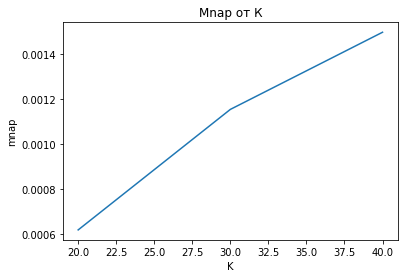

In [252]:
import matplotlib.pyplot as plt

plt.plot(np.arange(20, 50, 10), mnaps)
plt.xlabel('K')
plt.ylabel('mnap')
plt.title('Mnap от К')
plt.show()

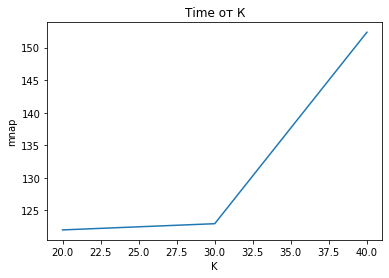

In [253]:
plt.plot(np.arange(20, 50, 10), times)
plt.xlabel('K')
plt.ylabel('mnap')
plt.title('Time от К')
plt.show()

### Задание 6

#### Content-based

В соревновании осталось много неиспользуемых нами данных. 
Сформируйте из них признаковое описание пары (пользователь, фильм), придумав минимум 10 содержательных (!) признаков. Целевой переменной, как и раньше, будет являться доля времени взаимодействия пользователя и фильма. Соберите данные, обучите на полученных данных линейную регрессию и градиентный бустинг. 
Для каждого пользователя из тестовой выборки предскажите 20 фильмов, с максимальной долей времени взаимодействия. Оцените качество предсказания с помощью функции `mnap_k` при `k=20`. Какого качество удалось достичь?

In [292]:
bookmarks = pd.read_csv('data/bookmarks.csv')
bookmarks = bookmarks.merge(catalogue, left_on="element_uid", right_index=True, how="left")
bookmarks['consumption_mode'] = 'B'
bookmarks['potreblenie'] = 0
bookmarks['book'] = 1
ratings['potreblenie'] = 1
ratings['consumption_mode'] = 'R'
rat = ratings.drop(columns=["rating"])

df = transactions_train.copy()
df = df.append(bookmarks)
df = df.append(rat)
df.book.fillna(0, inplace=True)
df.drop(columns=["availability", "attributes"], inplace=True)
df = df[~df.target.isna()]
df['potreblenie'] = (df.consumption_mode.isin(["P", "R"]) |
                         ((df.target > 0.5) & (df.type != "series")) | 
                         ((df.target > 1/3) & (df.type == "series"))).astype(int)
df.drop(columns=['element_uid_x', 'index', 'watched_time', 'element_uid_y'], inplace = True)

In [293]:
X = df.drop(columns='target')

In [294]:
y = df['target']

In [ ]:
from sklearn.linear_model import LinearRegression

### Бонусное задание [3+ бонусных балла]

Используя любые данные из [конкурса](https://boosters.pro/championship/rekko_sand/overview), постройте предсказания для тестовой выборки из соревнования, отправьте свое решение и преодолейте в лидерборде порог `0.03`.

Подробно опишите ваше решение.

За преодоление порога вы можете получить от 3 баллов — конкретный балл будет зависеть от качества решения по сравнению с другими студентами, также выполнившими это задание.